<a href="https://colab.research.google.com/github/dema-u/keras_triplet_descriptor/blob/master/DLCW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU CHECKS AND IMPORTING DATA

Check GPU and import relevant libraries.

In [5]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  
printm()

import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)


('RAM Free: 12.8 GB', ' | Proc size: 339.4 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


Importing the data.

In [6]:
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
  
%cd /content/keras_triplet_descriptor  

!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
  
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

fatal: destination path 'keras_triplet_descriptor' already exists and is not an empty directory.
/content/keras_triplet_descriptor
--2019-03-04 20:21:36--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.27.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-04 20:21:36--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-04 20:21:36--  https://imperialcollegelondon.app.box

In [0]:
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

#denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
#denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

### TESTING THE BASELINE CODE

In [0]:
def get_denoise_model_baseline(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net

Defining the model and the loss for the descriptor network.

*get_descriptor_model* is only defined for one branch, but the whole model actually has three branches.

In [0]:
def get_descriptor_model_baseline(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model

def triplet_loss_baseline(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

Compiling the model with all the relevant hyperparameters.

Deleting all previous models before compiling the new one.

In [0]:
try: del denoise_model_baseline_baseline except: print("The model has not been initialized. Compiling...")

shape = (32, 32, 1)
denoise_model_baseline = get_denoise_model_baseline(shape)

sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
denoise_model_baseline.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])

Training the model.

In [10]:
denoise_history_baseline = denoise_model_baseline.fit_generator(generator=denoise_generator, epochs=10, verbose=1, validation_data=denoise_generator_val)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1436/1436 [==============================] - 40s 28ms/step - loss: 8.5351 - mean_absolute_error: 8.5351 - val_loss: 5.5909 - val_mean_absolute_error: 5.5909
Epoch 2/10
1436/1436 [==============================] - 35s 25ms/step - loss: 6.5198 - mean_absolute_error: 6.5198 - val_loss: 5.3035 - val_mean_absolute_error: 5.3035
Epoch 3/10
1436/1436 [==============================] - 35s 25ms/step - loss: 6.2462 - mean_absolute_error: 6.2462 - val_loss: 5.4707 - val_mean_absolute_error: 5.4707
Epoch 4/10
1436/1436 [==============================] - 36s 25ms/step - loss: 6.1014 - mean_absolute_error: 6.1014 - val_loss: 5.1170 - val_mean_absolute_error: 5.1170
Epoch 5/10
1436/1436 [==============================] - 35s 25ms/step - loss: 6.0147 - mean_absolute_error: 6.0147 - val_loss: 4.9112 - val_mean_absolute_error: 4.9112
Epoch 6/10
1436/1436 [==============================] - 36s 25ms/step - loss: 5.9624 - mean_absolute_error: 5.96

De-noising model *training* curves.

Show the possible keys to the history of the model.

In [11]:
print(denoise_history_baseline.history.keys())

['val_mean_absolute_error', 'loss', 'mean_absolute_error', 'val_loss']


Text(0.5,0,'Number of epochs')

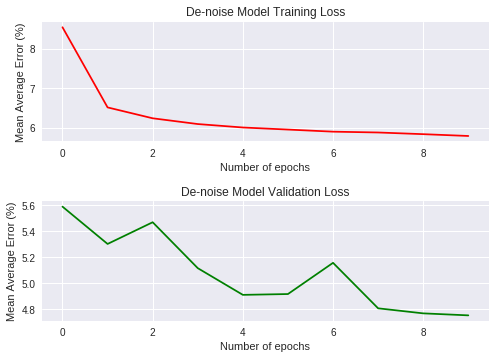

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1)
axes[0].plot(denoise_history_baseline.history['mean_absolute_error'], 'r')
axes[0].set_title('De-noise Model Training Loss')
axes[0].set_ylabel('Mean Average Error (%)')
axes[0].set_xlabel('Number of epochs')

fig.subplots_adjust(hspace=0.5)

axes[1].plot(denoise_history_baseline.history['val_mean_absolute_error'], 'g')
axes[1].set_title('De-noise Model Validation Loss')
axes[1].set_ylabel('Mean Average Error (%)')
axes[1].set_xlabel('Number of epochs')

Denoising the data from before.

In [14]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames, denoise_model=denoise_model, use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using denoised patches
100%|██████████| 116/116 [00:32<00:00,  2.55it/s]
Denoising patches...
100%|██████████| 15589/15589 [04:01<00:00, 64.64it/s]


100%|██████████| 100000/100000 [00:01<00:00, 79036.96it/s]


Using denoised patches
100%|██████████| 116/116 [00:19<00:00,  6.09it/s]
Denoising patches...
100%|██████████| 9525/9525 [02:27<00:00, 64.65it/s]


100%|██████████| 10000/10000 [00:00<00:00, 85963.12it/s]


Compiling our model with all the hyperparameters.

In [17]:
from keras.layers import Lambda

try: del descriptor_model except: print("The model has not been initialized. Compiling...")

shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model = Model(inputs=[xa, xp, xn], outputs=loss)

sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model.compile(loss='mean_absolute_error', optimizer=sgd)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.2157

100%|██████████| 100000/100000 [00:03<00:00, 27814.66it/s]


2000/2000 [==============================] - 160s 80ms/step - loss: 0.2157 - val_loss: 0.2304
Epoch 2/10
  10/2000 [..............................] - ETA: 2:54 - loss: 0.2048

  0%|          | 0/10000 [00:00<?, ?it/s]

  11/2000 [..............................] - ETA: 2:52 - loss: 0.1969

 36%|███▌      | 3611/10000 [00:00<00:00, 36106.76it/s]

  13/2000 [..............................] - ETA: 2:51 - loss: 0.1996

 70%|███████   | 7029/10000 [00:00<00:00, 35412.07it/s]

  14/2000 [..............................] - ETA: 2:49 - loss: 0.1940

100%|██████████| 10000/10000 [00:00<00:00, 35937.74it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1614

 91%|█████████ | 90821/100000 [00:03<00:00, 34819.03it/s]

2000/2000 [==============================] - 158s 79ms/step - loss: 0.1614 - val_loss: 0.2032


 96%|█████████▌| 96169/100000 [00:03<00:00, 37229.23it/s]

Epoch 3/10


100%|██████████| 100000/100000 [00:03<00:00, 26809.37it/s]


   8/2000 [..............................] - ETA: 5:44 - loss: 0.1654

  0%|          | 0/10000 [00:00<?, ?it/s]

   9/2000 [..............................] - ETA: 5:24 - loss: 0.1736

 44%|████▍     | 4388/10000 [00:00<00:00, 43876.07it/s]

  11/2000 [..............................] - ETA: 4:54 - loss: 0.1840

100%|██████████| 10000/10000 [00:00<00:00, 36940.71it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1461

 90%|█████████ | 90070/100000 [00:03<00:00, 34838.53it/s]

2000/2000 [==============================] - 158s 79ms/step - loss: 0.1461 - val_loss: 0.1717


 94%|█████████▎| 93726/100000 [00:03<00:00, 35334.61it/s]

Epoch 4/10


100%|██████████| 100000/100000 [00:03<00:00, 25425.18it/s]


   6/2000 [..............................] - ETA: 7:59 - loss: 0.1521

  0%|          | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 7:11 - loss: 0.1359

 42%|████▏     | 4182/10000 [00:00<00:00, 41814.96it/s]

   9/2000 [..............................] - ETA: 6:12 - loss: 0.1433

100%|██████████| 10000/10000 [00:00<00:00, 36911.81it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1370

 96%|█████████▌| 96115/100000 [00:03<00:00, 33819.64it/s]

2000/2000 [==============================] - 159s 80ms/step - loss: 0.1369 - val_loss: 0.1831


100%|██████████| 100000/100000 [00:03<00:00, 28898.78it/s]


Epoch 5/10
  10/2000 [..............................] - ETA: 3:30 - loss: 0.1359

  0%|          | 0/10000 [00:00<?, ?it/s]

  11/2000 [..............................] - ETA: 3:25 - loss: 0.1370

 45%|████▍     | 4492/10000 [00:00<00:00, 44917.26it/s]

  13/2000 [..............................] - ETA: 3:18 - loss: 0.1374

100%|██████████| 10000/10000 [00:00<00:00, 37143.93it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1314

 96%|█████████▋| 96434/100000 [00:03<00:00, 32136.53it/s]

2000/2000 [==============================] - 158s 79ms/step - loss: 0.1313 - val_loss: 0.1993


100%|██████████| 100000/100000 [00:03<00:00, 28272.28it/s]

Epoch 6/10


   9/2000 [..............................] - ETA: 3:31 - loss: 0.0826

  0%|          | 0/10000 [00:00<?, ?it/s]

  10/2000 [..............................] - ETA: 3:35 - loss: 0.0848

 44%|████▍     | 4430/10000 [00:00<00:00, 44299.09it/s]

  12/2000 [..............................] - ETA: 3:25 - loss: 0.1004

 85%|████████▌ | 8531/10000 [00:00<00:00, 43256.75it/s]

  13/2000 [..............................] - ETA: 3:21 - loss: 0.1181

100%|██████████| 10000/10000 [00:00<00:00, 36303.16it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1263

 92%|█████████▏| 92197/100000 [00:03<00:00, 28757.55it/s]

2000/2000 [==============================] - 159s 80ms/step - loss: 0.1263 - val_loss: 0.1888


 97%|█████████▋| 96567/100000 [00:03<00:00, 31503.17it/s]

Epoch 7/10


100%|██████████| 100000/100000 [00:03<00:00, 26309.43it/s]


   6/2000 [..............................] - ETA: 5:52 - loss: 0.1321

  0%|          | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:24 - loss: 0.1171

 45%|████▍     | 4496/10000 [00:00<00:00, 44959.51it/s]

   9/2000 [..............................] - ETA: 4:48 - loss: 0.1184

 85%|████████▍ | 8473/10000 [00:00<00:00, 43265.69it/s]

  10/2000 [..............................] - ETA: 4:35 - loss: 0.1196

100%|██████████| 10000/10000 [00:00<00:00, 35791.24it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1220

 93%|█████████▎| 93423/100000 [00:03<00:00, 33104.75it/s]

2000/2000 [==============================] - 158s 79ms/step - loss: 0.1220 - val_loss: 0.1969


 97%|█████████▋| 97007/100000 [00:03<00:00, 33802.23it/s]

Epoch 8/10


100%|██████████| 100000/100000 [00:03<00:00, 27061.65it/s]


   7/2000 [..............................] - ETA: 6:31 - loss: 0.1321

  0%|          | 0/10000 [00:00<?, ?it/s]

   8/2000 [..............................] - ETA: 6:02 - loss: 0.1195

 42%|████▏     | 4229/10000 [00:00<00:00, 42287.92it/s]

   9/2000 [..............................] - ETA: 5:40 - loss: 0.1280

 89%|████████▊ | 8868/10000 [00:00<00:00, 43440.05it/s]

  10/2000 [..............................] - ETA: 5:22 - loss: 0.1187

100%|██████████| 10000/10000 [00:00<00:00, 36459.65it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1179

 96%|█████████▋| 96335/100000 [00:03<00:00, 33525.06it/s]

2000/2000 [==============================] - 159s 80ms/step - loss: 0.1179 - val_loss: 0.2107


100%|██████████| 100000/100000 [00:03<00:00, 28022.34it/s]


Epoch 9/10
  10/2000 [..............................] - ETA: 3:30 - loss: 0.1230

  0%|          | 0/10000 [00:00<?, ?it/s]

  11/2000 [..............................] - ETA: 3:25 - loss: 0.1161

 42%|████▏     | 4237/10000 [00:00<00:00, 42368.73it/s]

  13/2000 [..............................] - ETA: 3:18 - loss: 0.1085

 82%|████████▏ | 8239/10000 [00:00<00:00, 41633.97it/s]

  14/2000 [..............................] - ETA: 3:47 - loss: 0.1060

100%|██████████| 10000/10000 [00:00<00:00, 18519.03it/s]

  16/2000 [..............................] - ETA: 3:40 - loss: 0.1116

1999/2000 [============================>.] - ETA: 0s - loss: 0.1166

 97%|█████████▋| 96712/100000 [00:03<00:00, 37242.48it/s]

2000/2000 [==============================] - 158s 79ms/step - loss: 0.1167 - val_loss: 0.1634


100%|██████████| 100000/100000 [00:03<00:00, 28438.55it/s]


Epoch 10/10
   9/2000 [..............................] - ETA: 3:39 - loss: 0.0605

  0%|          | 0/10000 [00:00<?, ?it/s]

  11/2000 [..............................] - ETA: 3:29 - loss: 0.0522

 30%|██▉       | 2968/10000 [00:00<00:00, 29676.14it/s]

  12/2000 [..............................] - ETA: 3:24 - loss: 0.0487

 67%|██████▋   | 6729/10000 [00:00<00:00, 31680.52it/s]

  13/2000 [..............................] - ETA: 3:20 - loss: 0.0575

100%|██████████| 10000/10000 [00:00<00:00, 30789.89it/s]

  14/2000 [..............................] - ETA: 3:21 - loss: 0.0681

1999/2000 [============================>.] - ETA: 0s - loss: 0.1101

 96%|█████████▌| 95729/100000 [00:03<00:00, 32257.88it/s]

2000/2000 [==============================] - 159s 79ms/step - loss: 0.1101 - val_loss: 0.1533


100%|██████████| 10000/10000 [00:00<00:00, 61163.57it/s]


Training the descriptor model.

In [0]:
descriptor_history = descriptor_model.fit_generator(generator=training_generator, epochs=10, verbose=1, validation_data=val_generator)

Training curves for the descriptor.

Keys for the descriptor history if needed.

In [18]:
print(descriptor_history.history.keys())

['loss', 'val_loss']


Text(0.5,0,'Number of epochs')

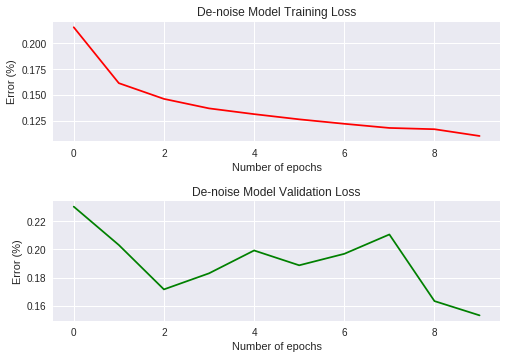

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1)
axes[0].plot(descriptor_history.history['loss'], 'r')
axes[0].set_title('De-noise Model Training Loss')
axes[0].set_ylabel('Error (%)')
axes[0].set_xlabel('Number of epochs')

fig.subplots_adjust(hspace=0.5)

axes[1].plot(descriptor_history.history['val_loss'], 'g')
axes[1].set_title('De-noise Model Validation Loss')
axes[1].set_ylabel('Error (%)')
axes[1].set_xlabel('Number of epochs')

Evaluation of the

In [20]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

100%|██████████| 40/40 [06:16<00:00,  8.25s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:20<00:00, 12350.96it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:21<00:00, 12342.10it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:20<00:00, 12349.36it/s]
>> Verification task finished in 251 secs  
Verification task results:
Mean Average Precision is 0.797795



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:03<00:00,  4.19s/it]
>> Matching task finished in 123 secs  
Matching task results:
Mean Average Precision is 0.189704





>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large a

### TESTING MY IMPROVED APPROACH

In [0]:
from keras.applications.resnet50 import ResNet50

def get_denoise_model_improved(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net

In [0]:
try: del denoise_model_improved
except: print("The model has not been initialized. Compiling...")

shape = (32, 32, 1)
denoise_model_improved = get_denoise_model_improved(shape)

sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
denoise_model_improved.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])

In [34]:
denoise_history_improved = denoise_model_improved.fit_generator(generator=denoise_generator, epochs=10, verbose=1, validation_data=denoise_generator_val)

Epoch 1/10
 - 39s - loss: 8.5208 - mean_absolute_error: 8.5208 - val_loss: 5.6274 - val_mean_absolute_error: 5.6274
Epoch 2/10
 - 36s - loss: 6.5133 - mean_absolute_error: 6.5133 - val_loss: 5.3491 - val_mean_absolute_error: 5.3491
Epoch 3/10
 - 36s - loss: 6.2477 - mean_absolute_error: 6.2477 - val_loss: 5.0916 - val_mean_absolute_error: 5.0916
Epoch 4/10
 - 36s - loss: 6.1257 - mean_absolute_error: 6.1257 - val_loss: 5.0701 - val_mean_absolute_error: 5.0701
Epoch 5/10
 - 36s - loss: 6.0307 - mean_absolute_error: 6.0307 - val_loss: 5.3773 - val_mean_absolute_error: 5.3773
Epoch 6/10
 - 36s - loss: 5.9641 - mean_absolute_error: 5.9641 - val_loss: 4.9506 - val_mean_absolute_error: 4.9506
Epoch 7/10
 - 36s - loss: 5.9439 - mean_absolute_error: 5.9439 - val_loss: 5.1131 - val_mean_absolute_error: 5.1131
Epoch 8/10
 - 36s - loss: 5.9131 - mean_absolute_error: 5.9131 - val_loss: 4.8330 - val_mean_absolute_error: 4.8330
Epoch 9/10
 - 36s - loss: 5.8614 - mean_absolute_error: 5.8614 - val_los

In [36]:
print(denoise_history_improved.history.keys())

['val_mean_absolute_error', 'loss', 'mean_absolute_error', 'val_loss']


Text(0.5,0,'Number of epochs')

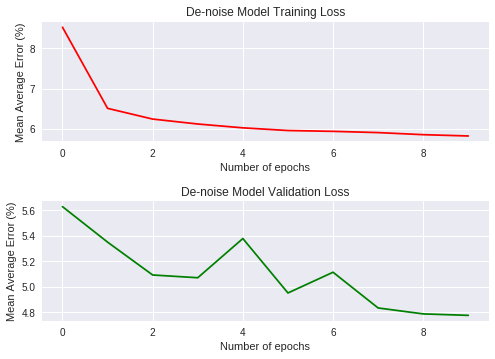

In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1)
axes[0].plot(denoise_history_improved.history['mean_absolute_error'], 'r')
axes[0].set_title('De-noise Model Training Loss')
axes[0].set_ylabel('Mean Average Error (%)')
axes[0].set_xlabel('Number of epochs')

fig.subplots_adjust(hspace=0.5)

axes[1].plot(denoise_history_improved.history['val_mean_absolute_error'], 'g')
axes[1].set_title('De-noise Model Validation Loss')
axes[1].set_ylabel('Mean Average Error (%)')
axes[1].set_xlabel('Number of epochs')